# PROJECT E-COMMERCE
## This project involves analyzing a dataset from an e-commerce platform to extract meaningful insights about sales performance, customer behavior, and product dynamics.
## The analysis combines SQL queries and Python data manipulation to answer a series of business questions and derive actionable intelligence.

In [1]:
import pandas as pd
import mysql.connector #establishing a connection to a MySQL database using the mysql-connector-python library. 
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),  # Added payments.csv for specific handling
    ('order_items.csv','order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='navneets-MacBook-Air.local',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/navneetnautiyal/Documents/data set/e-commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


# 1. List all unique cities where customers are located.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import mysql.connector #establishing a connection to a MySQL database using the mysql-connector-python library. 

db = mysql.connector.connect(host = 'navneets-MacBook-Air.local',  # This is the hostname or IP address of the MySQL server
                            username = 'root',  #This is the MySQL user account you're using to connect to the database
                            password = '1234',
                            database = 'ecommerce') #This specifies the database to use after connecting
#This connect method returns a connection object that you can use to interact with the MySQL database.

cur = db.cursor()
#This creates a cursor object using the connection. The cursor is used to execute SQL queries and fetch results from the database

In [3]:
query = """ select distinct customer_city from customers; """

cur.execute(query)

data = cur.fetchall()  #fetchall(): Fetches all rows from the executed query.
df=pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# 2. Count the number of orders placed in 2017.

In [18]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()  #fetchall(): Fetches all rows from the executed query.
df=pd.DataFrame(data)
df

,0
0,180404


# 3. Find the total sales per category.

In [19]:
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products 
join order_items
on products.product_id=order_items.product_id  #since there was no direct join from product to
join payments
on payments.order_id = order_items.order_id
group by category; """

cur.execute(query)

data = cur.fetchall()  #fetchall(): Fetches all rows from the executed query.
df=pd.DataFrame(data)
df

,0,1
0,perfumery,4075309.76
1,Furniture Decoration,11469968.73
2,telephony,3895553.33
3,bed table bath,13710812.25
4,automotive,6820567.81
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments.

In [20]:
a = """
select count(payment_installments)
from payments
where payment_installments >= 1
"""
cur.execute(a)

data_a = cur.fetchone()

data_a=int(data_a[0])
data_a

207768

In [22]:
b="""select count(payment_installments)
from payments
"""
cur.execute(b)

data_b = cur.fetchone()

data_b=int(data_b[0])
data_b

207772

In [23]:
print('percentage =',(data_a/data_b)*100)

percentage = 99.99807481277554


In [24]:
# or by  direct methord
query = """
select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100
from payments """

cur.execute(query)
# Fetch the result
data = cur.fetchone()

data[0]

Decimal('99.9981')

# 5. Count the number of customers from each state.

In [35]:
query = """
select customer_state, count(customer_unique_id)
from customers
group by customer_state
"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()

df = pd.DataFrame(data,columns=['state','count'])
df.head()

,state,count
0,SP,166984
1,SC,14548
2,MG,46540
3,PR,20180
4,RJ,51408


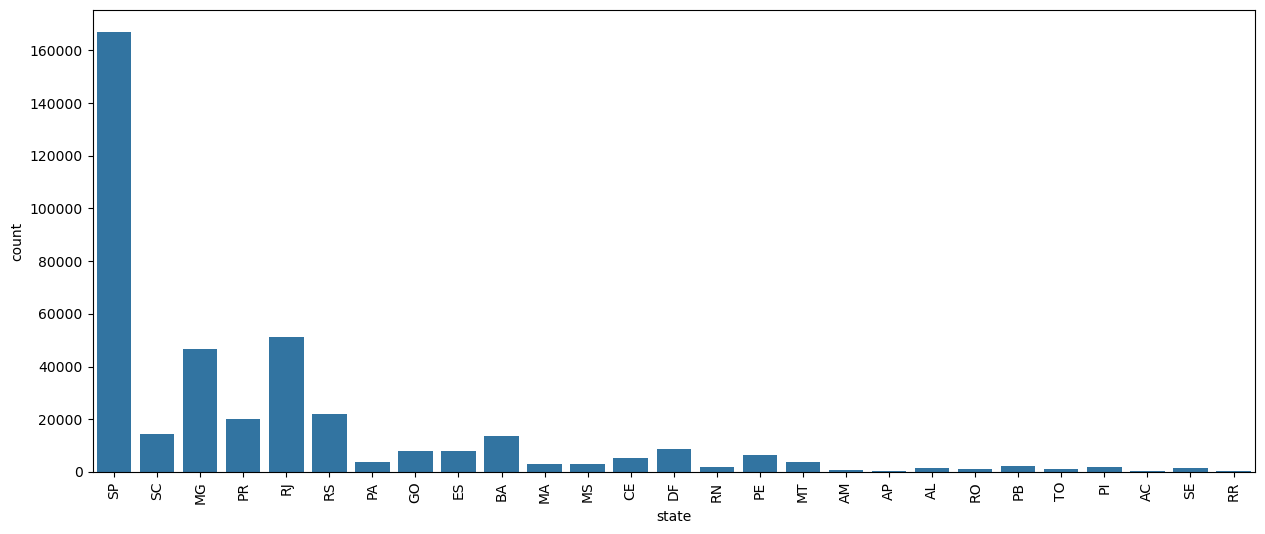

In [38]:
plt.figure(figsize=[15,6])
sns.barplot(x=df['state'],y=df['count'])
plt.xticks(rotation = 90)
plt.show()

# 6. Calculate the number of orders per month in 2018.¶

In [40]:
query = """
select monthname(order_purchase_timestamp) as months,
count(order_id) as order_count
from orders 
where year(order_purchase_timestamp) = 2018
group by months
""" 

cur.execute(query)

# Fetch the result
data = cur.fetchall()

data
df=pd.DataFrame(data,columns=('Months','Count'))

#setting order
o=['January','February','March','April','May','June','July','August','September','October']
df

,Months,Count
0,July,25168
1,August,26048
2,February,26912
3,June,24668
4,March,28844
5,January,29076
6,May,27492
7,April,27756
8,September,64
9,October,16


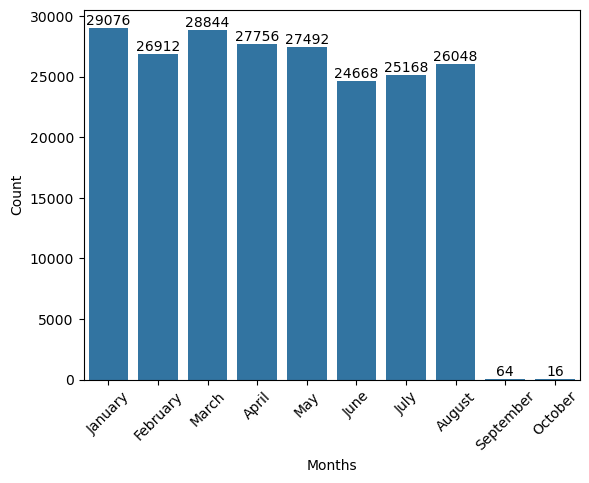

In [54]:
ax=sns.barplot(x='Months',y='Count',data=df,order=o)
plt.xticks(rotation=45)

ax.bar_label(ax.containers[0])
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [55]:
query = """
with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oi
from orders
join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oi),2) as average_order
from customers
join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city 
order by average_order"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()

data
df=pd.DataFrame(data,columns=['city','avg_orders'])
df

,city,avg_orders
0,brasopolis,8.00
1,campestre do maranhao,8.00
2,coreau,8.00
3,alto sao joao,8.00
4,campo alegre de minas,8.00
...,...,...
4105,matias olimpio,40.00
4106,candido godoi,48.00
4107,datas,48.00
4108,celso ramos,52.00


# 8. Calculate the percentage of total revenue contributed by each product category

In [56]:
query = """
select
products.product_category category,  #we have already calculated sales per product (3)
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products 
join order_items
on products.product_id=order_items.product_id  
join payments
on payments.order_id = order_items.order_id
group by category
order by sales desc;
""" 

cur.execute(query)

# Fetch the result
data = cur.fetchall()

df=pd.DataFrame(data,columns=['product','sales%'])
df

,product,sales%
0,bed table bath,42.82
1,HEALTH BEAUTY,41.44
2,computer accessories,39.62
3,Furniture Decoration,35.82
4,Watches present,35.74
...,...,...
69,PC Gamer,0.05
70,House Comfort 2,0.04
71,cds music dvds,0.03
72,Fashion Children's Clothing,0.02


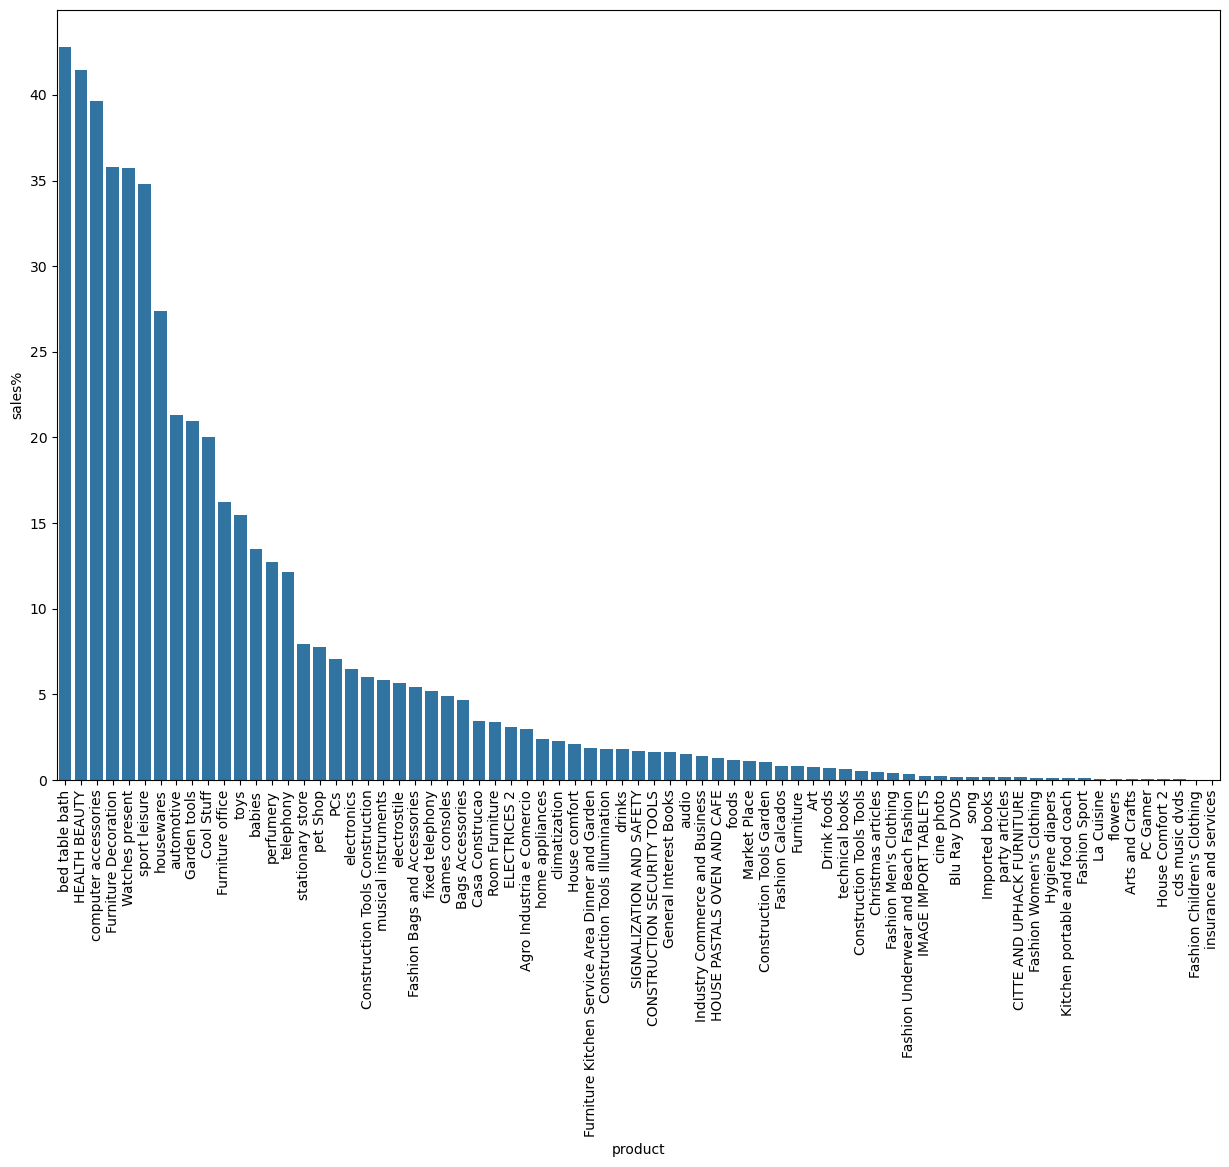

In [57]:
plt.figure(figsize=(15,10),)
sns.barplot(x=df['product'],y=df['sales%'])
plt.xticks(rotation=90)
plt.show()

# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [59]:
query = """
select products.product_category as products,
count(order_items.product_id) as count,
round(avg(order_items.price),2) as avg_price
from products
join order_items
on products.product_id=order_items.product_id
group by products.product_category
""" 

cur.execute(query)

# Fetch the result
data = cur.fetchall()
df=pd.DataFrame(data,columns=['product','count','avg price'])
df

,product,count,avg price
0,HEALTH BEAUTY,38724,130.11
1,sport leisure,34582,114.39
2,Cool Stuff,15326,171.16
3,computer accessories,31326,116.50
4,Watches present,23996,201.03
...,...,...,...
69,flowers,132,33.64
70,Kitchen portable and food coach,60,264.57
71,CITTE AND UPHACK FURNITURE,152,114.95
72,House Comfort 2,120,25.34


In [60]:
#now finding corelation
import numpy as np

In [61]:
c=df['count']
p=df['avg price']

np.corrcoef(c,p)

array([[ 1.        , -0.10597567],
       [-0.10597567,  1.        ]])

#### hence, ignoring diagonal value
#### we can see the values are very closes to 0, therefore there is no relation between them

# 10. Calculate the total revenue generated by each seller, and rank them by revenue

In [62]:
query = """
select *,dense_rank()over(order by revenue desc) as rn
from
(select
order_items.seller_id,round(sum(payments.payment_value),2) as revenue
from order_items
join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id)as a"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()
df=pd.DataFrame(data,columns=['Seller id','revenue','rank'])
df

,Seller id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,76.84,3076
3091,702835e4b785b67a084280efca355756,74.24,3077
3092,4965a7002cca77301c82d3f91b82e1a9,65.44,3078
3093,77128dec4bec4878c37ab7d6169d6f26,60.88,3079


# 11. Calculate the moving average of order values for each customer over their order history.

In [65]:
query = """
select 
	customer_id,
	order_purchase_timestamp,
	payment,
	avg(payment) over (
		partition by customer_id 
        order by order_purchase_timestamp
        rows between 2 preceding and current row) as moving_average
from 
	(select orders.customer_id,orders.order_purchase_timestamp,
	payments.payment_value as payment
	from payments join orders
	on payments.order_id = orders.order_id) as a;
"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
831083,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831084,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831085,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831086,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 12. Calculate the cumulative sales per month for each year.

In [63]:
query = """
select years,months, payments,
round(sum(payments) over (order by years, months),2) as cumulative_Sales
from
(select
	year(orders.order_purchase_timestamp) as years,
    month(orders.order_purchase_timestamp) as months,
    round(sum(payments.payment_value),2) as payments
from orders
    join payments
    on orders.order_id = payments.order_id
    group by years ,months order by years , months) as a;"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()
pd.options.display.float_format = '{:,.2f}'.format   #Convert the Scientific Notation to Float:

df= pd.DataFrame(data,columns=['year','months','payment','cumulative_sales'])

df

,year,months,payment,cumulative_sales
0,2016,9,"3,783.60","3,783.60"
1,2016,10,"886,357.20","890,140.80"
2,2016,12,294.30,"890,435.10"
3,2017,1,"2,077,320.60","2,967,755.70"
4,2017,2,"4,378,620.14","7,346,375.84"
5,2017,3,"6,747,953.99","14,094,329.83"
6,2017,4,"6,266,820.44","20,361,150.27"
7,2017,5,"8,893,782.30","29,254,932.57"
8,2017,6,"7,669,145.70","36,924,078.27"
9,2017,7,"8,885,743.79","45,809,822.06"


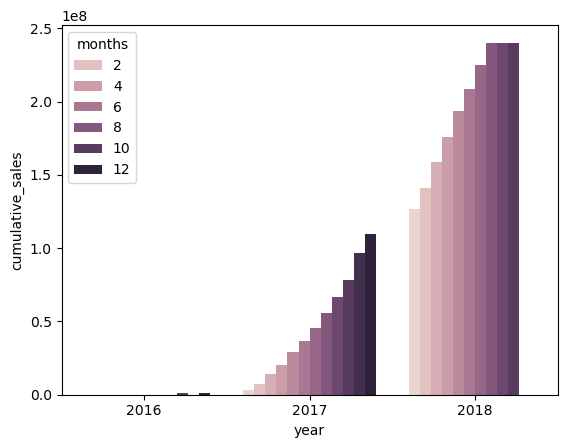

In [74]:
sns.barplot(x='year',y='cumulative_sales',hue='months',data=df)
plt.show()

# 13. Calculate the year-over-year growth rate of total sales.

In [61]:
query = """
select years, payments,
lag(payments,1) over (order by years) as previous_payments,
round(((payments - (lag(payments,1) over (order by years))) /
lag(payments,1) over (order by years)) *100,2) as year_growth
from
(select
	year(orders.order_purchase_timestamp) as years,
    round(sum(payments.payment_value),2) as payments
from orders
    join payments
    on orders.order_id = payments.order_id
    group by years order by years) as a;"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()
data 
pd.options.display.float_format = '{:,.2f}'.format

df = pd.DataFrame(data,columns=['year','sales','previous_year','yoy_growth%'])
df

,year,sales,previous_year,yoy_growth%
0,2016,"890,435.10",NaN,NaN
1,2017,"108,746,200.92","890,435.10","12,112.70"
2,2018,"130,496,445.78","108,746,200.92",20.00


<Axes: xlabel='year', ylabel='yoy_growth%'>

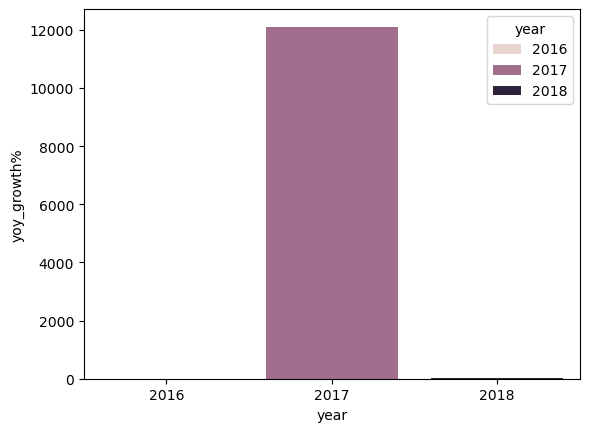

In [62]:
sns.barplot(x='year',y='yoy_growth%',hue='year',data=df)

# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [71]:
query = """
with a as (select
        customers.customer_id,
        min(orders.order_purchase_timestamp) as first_order
    from customers
    join orders
    on customers.customer_id = orders.customer_id
    group by customers.customer_id
),
b as ( select
        a.customer_id,
        count(distinct orders.order_purchase_timestamp) as next_order
    from a
    join orders
    on orders.customer_id = a.customer_id
    and orders.order_purchase_timestamp > a.first_order
    and orders.order_purchase_timestamp < date_add(a.first_order, interval 6 month)
    group by a.customer_id
)
select
    100 * (COUNT(distinct b.customer_id) / COUNT(distinct a.customer_id)) as percentage
FROM a
LEFT JOIN b
ON a.customer_id = b.customer_id;"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()
df= pd.DataFrame(data)
df

,0
0,0.0000


# 15. Identify the top 3 customers who spent the most money in each year.

In [5]:
query = """
select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;"""

cur.execute(query)

# Fetch the result
data = cur.fetchall()
df= pd.DataFrame(data,columns = ['year','id','payment','rank'])
df

,year,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,21353.250732,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,21011.099854,2
2,2016,4a06381959b6670756de02e07b83815f,18416.700439,3
3,2017,1617b1357756262bfa56ab541c47bc16,204961.201172,1
4,2017,c6e2731c5b391845f6800c97401a43a9,103939.650879,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,100899.902344,3
6,2018,ec5b2ba62e574342386871631fafd3fc,109123.198242,1
7,2018,f48d464a0baaea338cb25f816991ab1f,103833.149414,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,72141.599121,3


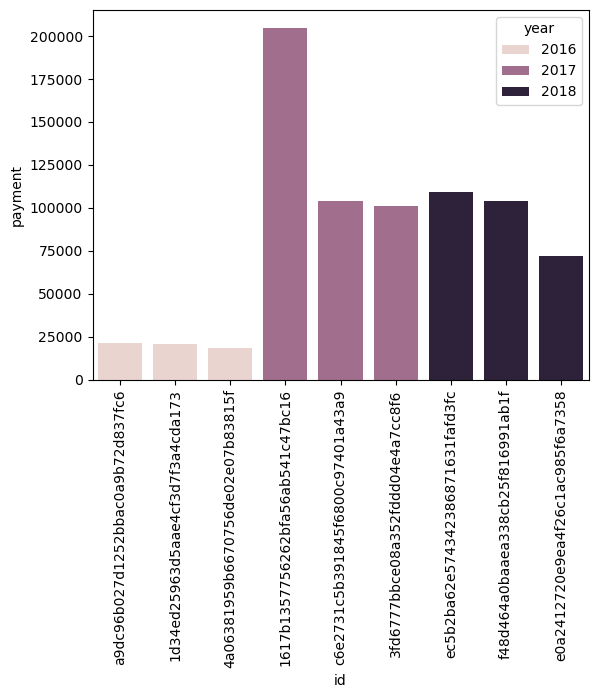

In [8]:
sns.barplot(x='id',y='payment',hue='year',data=df)
plt.xticks(rotation = 90)
plt.show()